In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,confusion_matrix,precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 1) import data and cleaning

In [2]:
#import data
data = pd.read_csv('nearest-earth-objects(1910-2024).csv')

data.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [3]:
#shape of data 
data.shape

(338199, 9)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [5]:
#summary for columns
data.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [6]:
#there is no duplicated
data.duplicated().sum()

0

In [7]:
#there is some missing value 
data.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [8]:
#here treat the missing
data.dropna(inplace=True)

In [9]:
#check
data.isnull().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

# 2) Explore Data

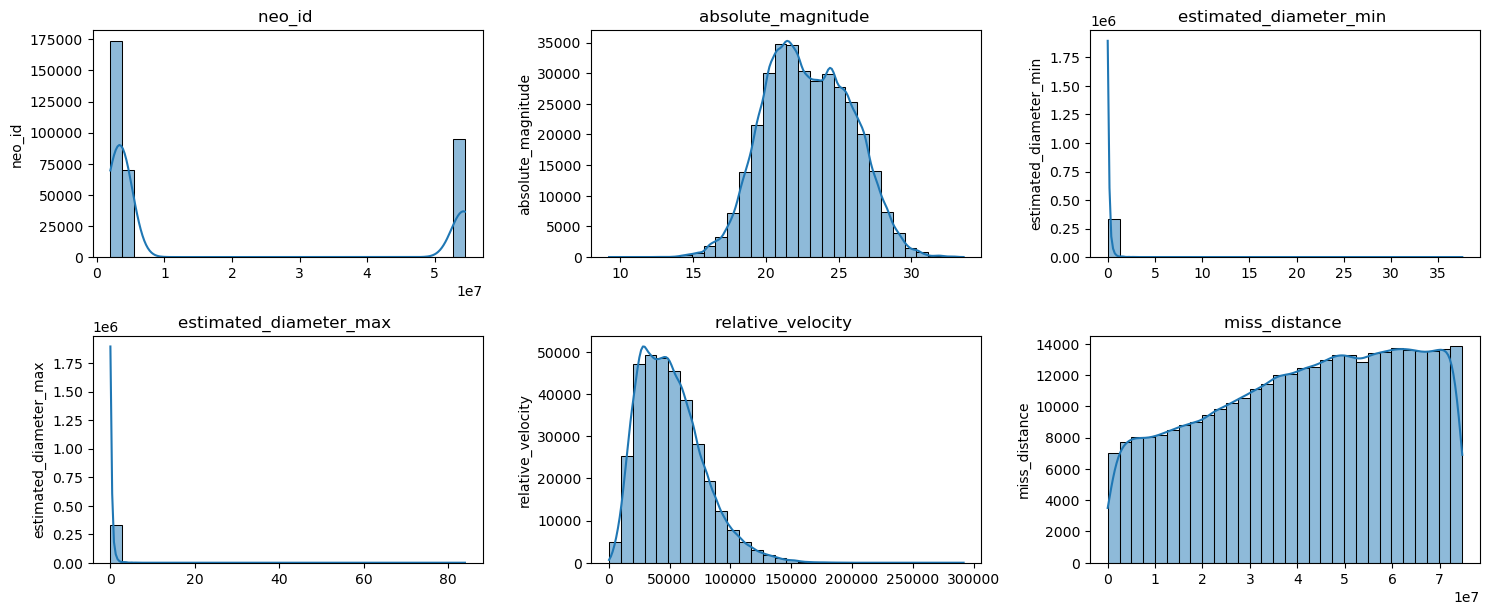

In [10]:
#barplot for data
plt.figure(figsize=(15, 15))
for i, feature in enumerate(data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(data=data, x=feature, bins=30, kde=True)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

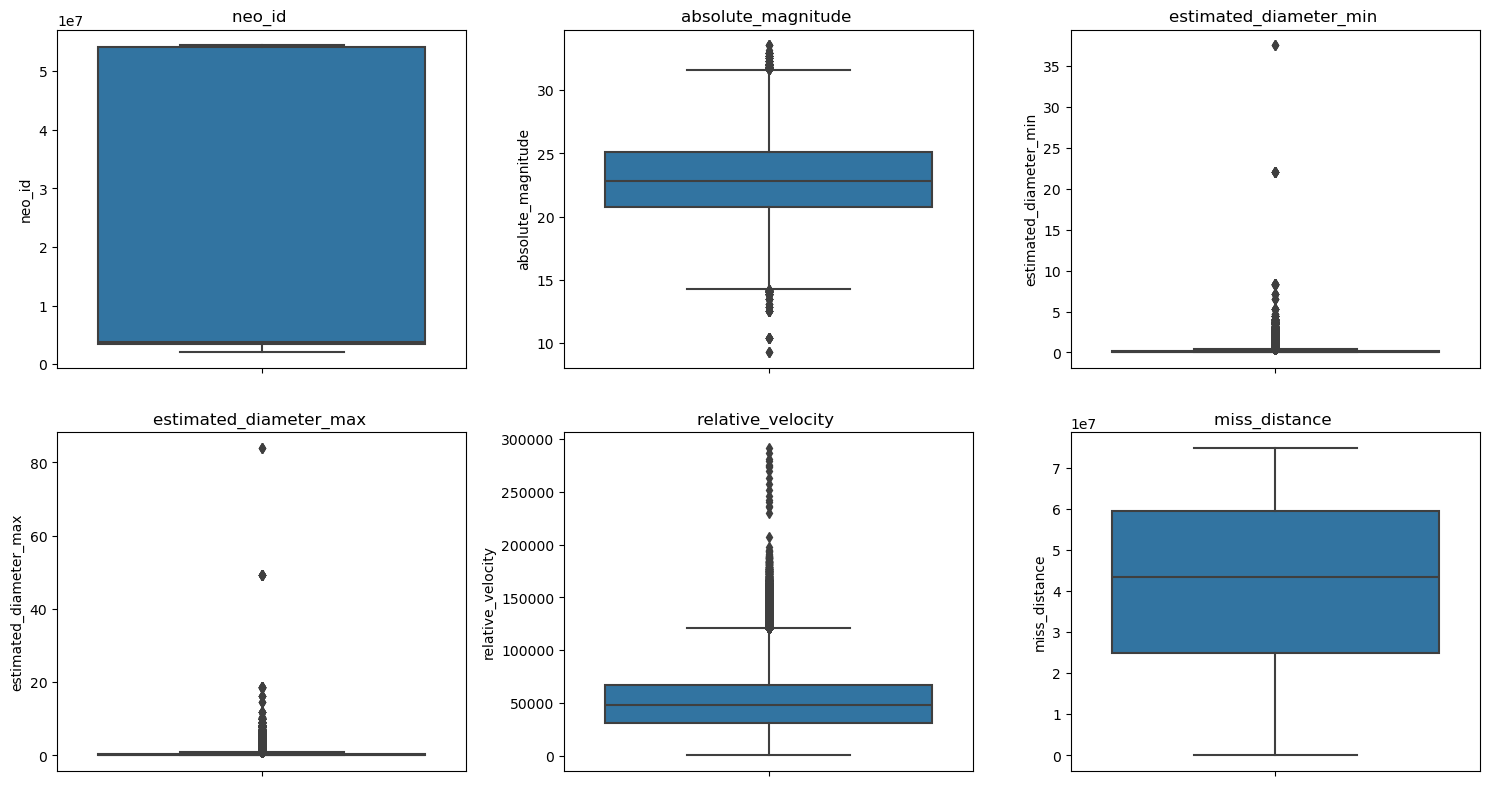

In [11]:
#box plot for numric data ,it seems there is outliers 
plt.figure(figsize=(15, 20))

for i, feature in enumerate(data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=data, y=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

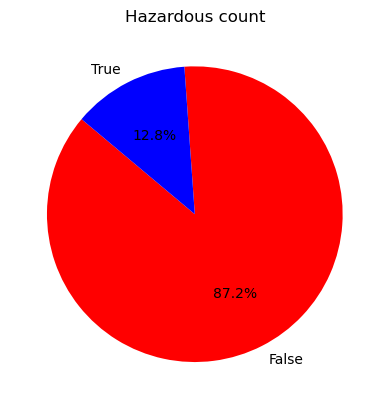

In [12]:
#count for hazardous
har_count=data['is_hazardous'].value_counts()
plt.pie(har_count, labels=har_count.index, colors=['r','b'],autopct='%1.1f%%', startangle=140)
plt.title('Hazardous count')
plt.show()

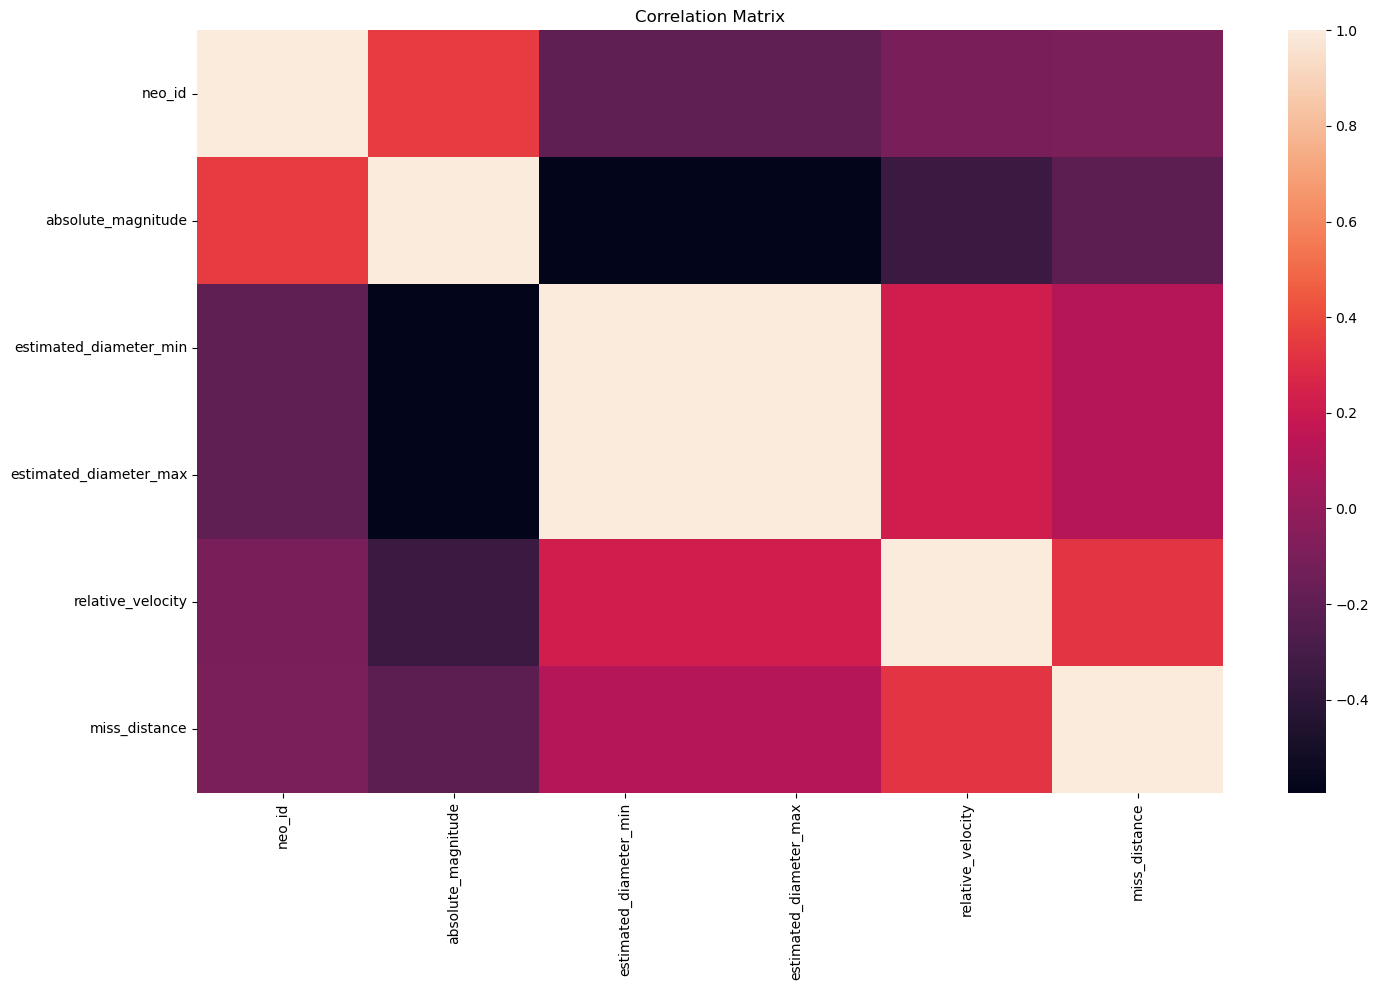

In [13]:
corr = data.select_dtypes(include='number').corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 3) preprocessing data

In [14]:
#here well delete the outliers
features_list = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max", "relative_velocity"]

for feature in features_list:
    global data
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1

    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)

    data = data.loc[(data[feature] < upper_limit) & (data[feature] > lower_limit)]

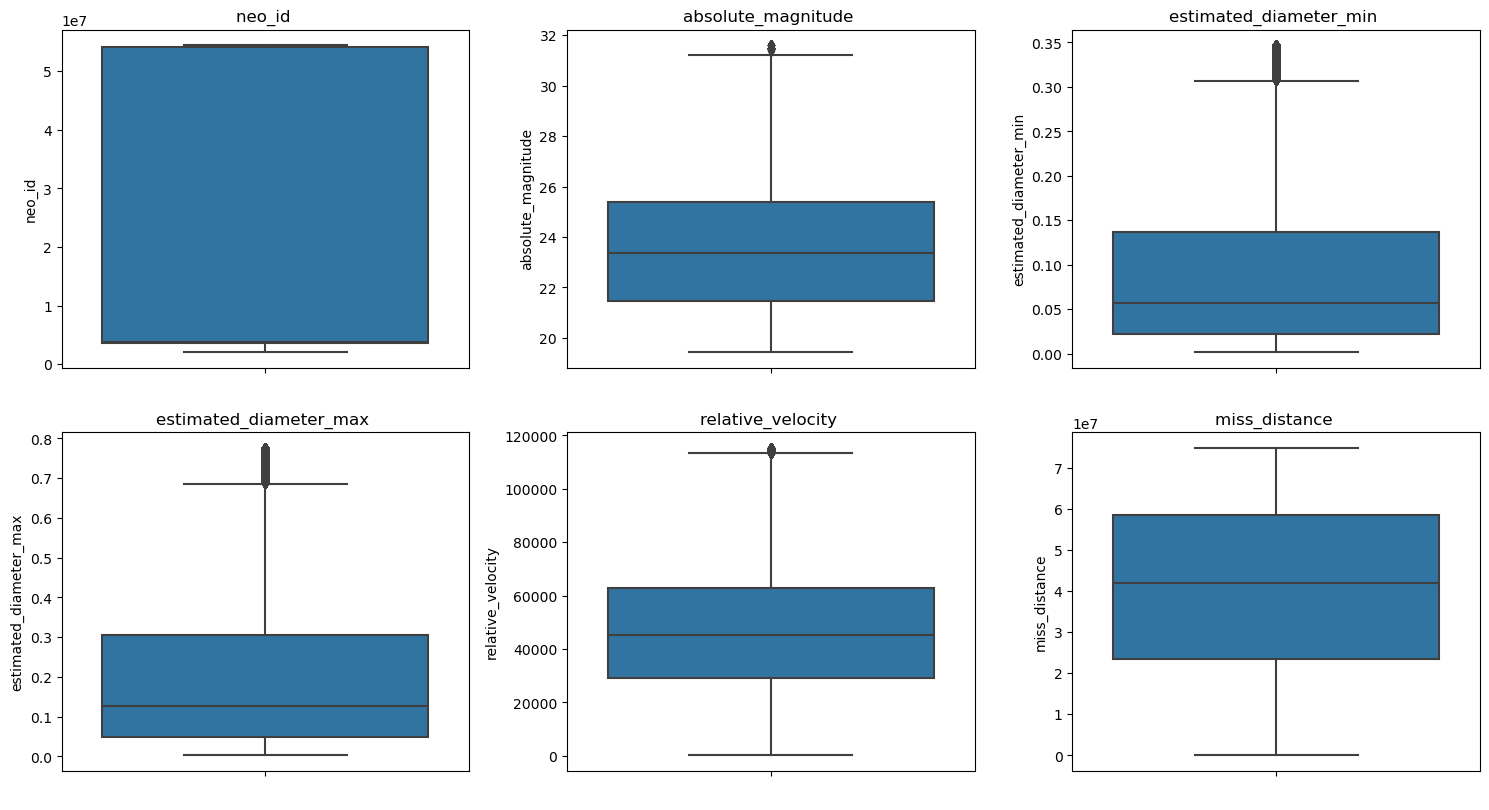

In [15]:
plt.figure(figsize=(15, 20))

for i, feature in enumerate(data.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=data, y=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [16]:
#data selection for analysis
df= data.drop(['neo_id','name','orbiting_body'], axis=1)

In [17]:
df

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
2,21.450,0.136319,0.304818,24865.506798,6.720689e+07,False
3,20.630,0.198863,0.444672,78890.076805,3.039644e+07,False
4,22.700,0.076658,0.171412,56036.519484,6.311863e+07,False
5,25.000,0.026580,0.059435,47477.649832,4.290521e+07,False
6,21.500,0.133216,0.297879,57853.295346,2.727908e+07,True
...,...,...,...,...,...,...
338194,28.580,0.005112,0.011430,56646.985988,6.406548e+07,False
338195,28.690,0.004859,0.010865,21130.768947,2.948883e+07,False
338196,21.919,0.109839,0.245607,11832.041031,5.346078e+07,False
338197,23.887,0.044377,0.099229,56198.382733,5.184742e+06,False


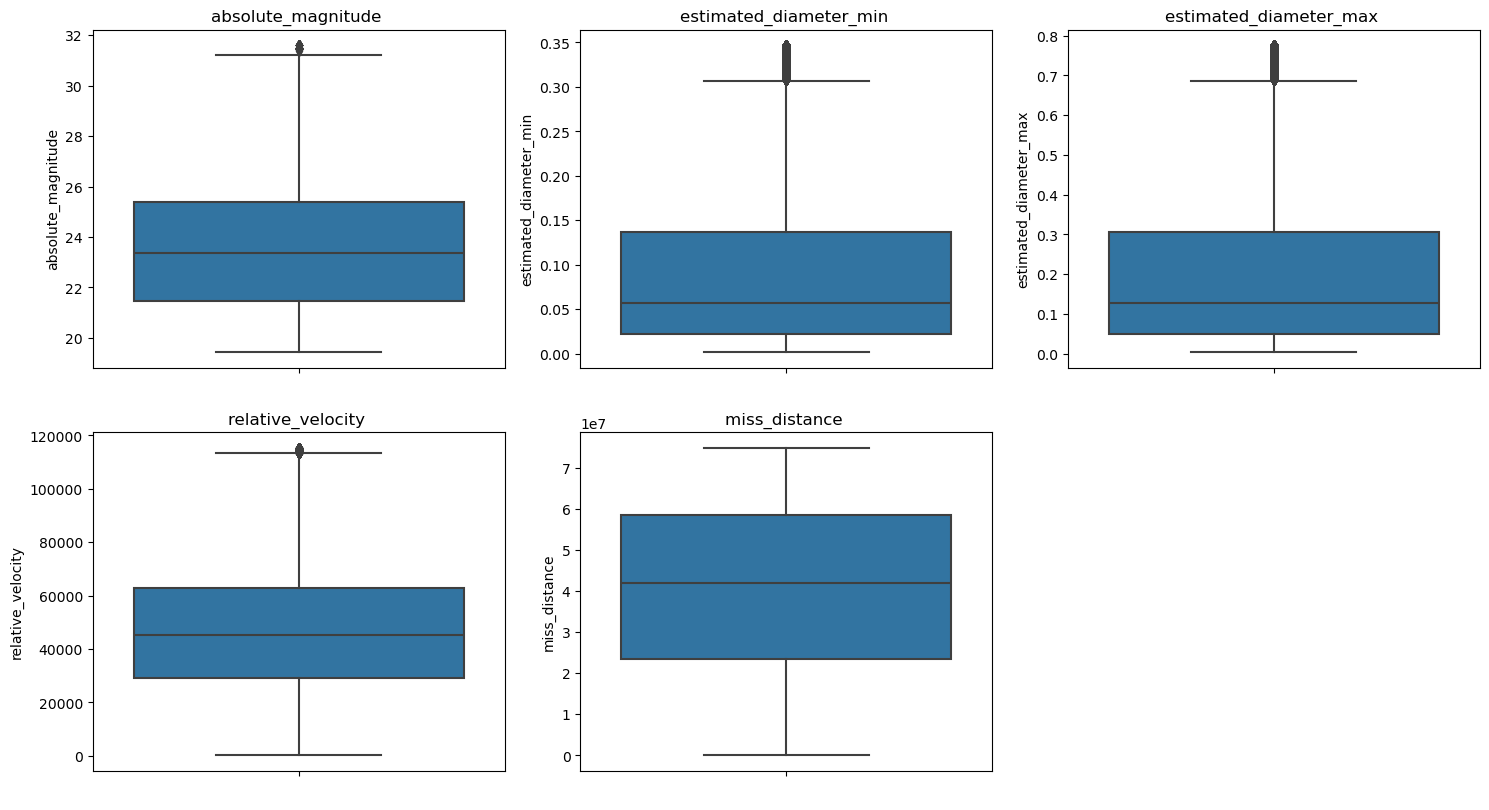

In [27]:
plt.figure(figsize=(15, 20))

for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# 4) Model Training and Evaluation

In [30]:
#select data for model
X = df.drop('is_hazardous', axis=1)
y = df['is_hazardous']

#split data for train model first and test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)


In [31]:
#Handle Imbalanced Data
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

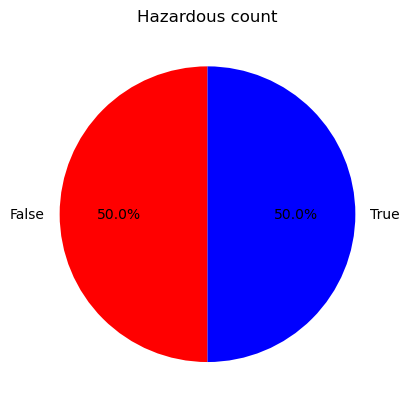

In [20]:
#balanced hazardous
plt.pie(y_train_resampled.value_counts(), labels=har_count.index, colors=['r','b'],autopct='%1.1f%%', startangle=90)
plt.title('Hazardous count')
plt.show()

In [21]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

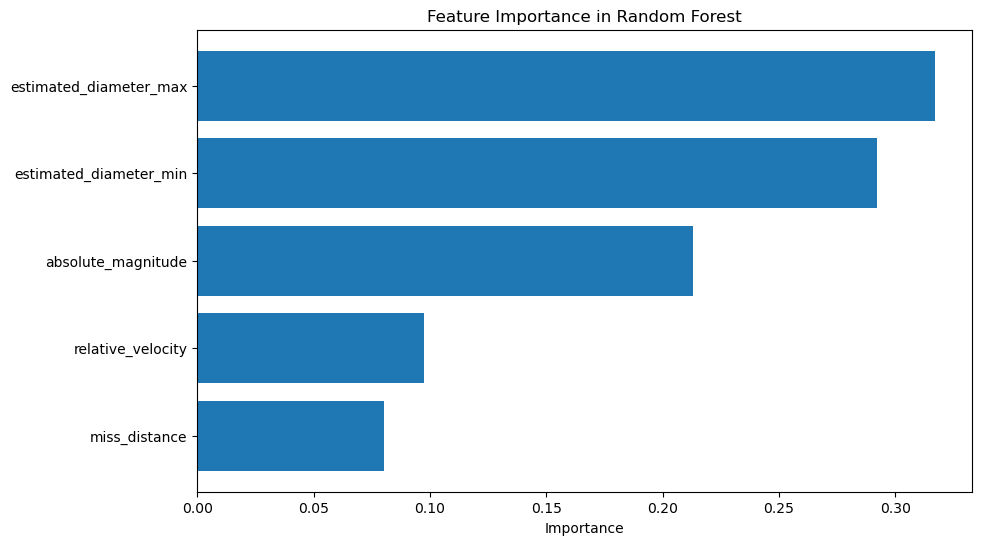

In [22]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.96      0.96      0.96     52716
        True       0.67      0.64      0.65      6438

    accuracy                           0.93     59154
   macro avg       0.81      0.80      0.81     59154
weighted avg       0.92      0.93      0.93     59154



In [24]:
# Predictions (assuming y_test and y_pred are defined)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, F1-score, and AUC-ROC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')


Precision: 0.67
Recall: 0.64
F1-Score: 0.65
ROC AUC: 0.95


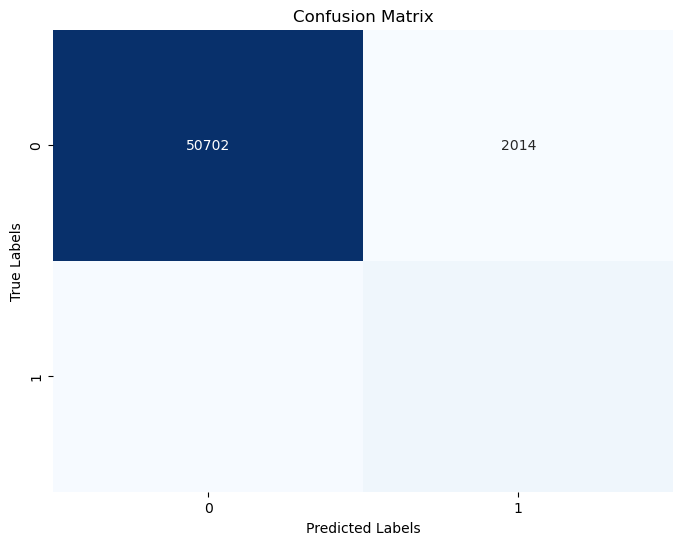

In [25]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


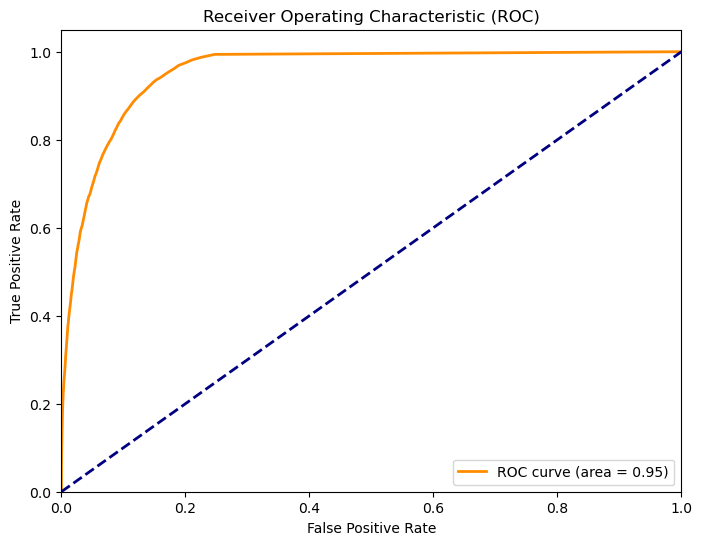

In [26]:
# Get the predicted probabilities for the positive class
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

